In [1]:
import sys
sys.path.insert(0,"../../")

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import *
from bs4.element import PageElement
import time
from base import *

folder = ""
host = f'basketball-reference.com'

In [113]:
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

Label:
- Index: Match & Team
- Time: From Season 2000
- Dependent : Game result, Net pts, Total pts


In [56]:
all_gamelog_prior = pd.read_csv(f"{folder}data/gamelog-prior-all/regular.csv")\
                            .drop(columns="Unnamed: 0")\
                            .rename(columns={'team_id_teamA':'team_id','opp_id_teamA':'opp_id','date_game_teamA':'date_game'})\
                            .set_index(['date_game_href','team_id','opp_id'])
all_gamelog_prior.loc[:,'date_game'] = pd.to_datetime(all_gamelog_prior['date_game'])
all_gamelog_prior.loc[:,['h2h_result_prior_teamA','h2h_result_prior_teamB']] = all_gamelog_prior.loc[:,['h2h_result_prior_teamA','h2h_result_prior_teamB']].fillna(0.5)

period = (all_gamelog_prior['date_game'] > pd.Timestamp("1999-10-01")) & (all_gamelog_prior['date_game'] < pd.Timestamp("2022-10-01")) 
valid_rows = (all_gamelog_prior['game_season_teamA'] > 10) & (all_gamelog_prior['game_season_teamB'] > 10)
X0 = all_gamelog_prior.loc[(period & valid_rows)]
X0

# all_gamelog_prior

,,,game_season_teamA,date_game,team_id_href_teamA,game_location_teamA,opp_id_href_teamA,game_result_teamA,rest_days_prior_teamA,result_prior_teamA,location_result_prior_teamA,h2h_result_prior_teamA,...,blk_pct_last10_delta_teamB,efg_pct_last10_delta_teamB,tov_pct_last10_delta_teamB,orb_pct_last10_delta_teamB,ft_rate_last10_delta_teamB,opp_efg_pct_last10_delta_teamB,opp_tov_pct_last10_delta_teamB,drb_pct_last10_delta_teamB,opp_ft_rate_last10_delta_teamB,net_rtg_last10_delta_teamB
date_game_href,team_id,opp_id,,,,,,,,,,,,,,,,,,,,,
/boxscores/202111090UTA.html,ATL,UTA,12,2021-11-09,/teams/ATL/2022.html,False,/teams/UTA/2022.html,False,1,0.363636,0.142857,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
/boxscores/202111120DEN.html,ATL,DEN,13,2021-11-12,/teams/ATL/2022.html,False,/teams/DEN/2022.html,False,3,0.333333,0.125000,0.500000,...,0.676364,-0.010955,-0.282727,0.530000,0.007091,0.001445,-0.203636,0.201818,0.002436,-0.870909
/boxscores/202111140ATL.html,ATL,MIL,14,2021-11-14,/teams/ATL/2022.html,True,/teams/MIL/2022.html,True,2,0.307692,0.750000,0.500000,...,-0.014615,-0.004515,-0.256154,1.220769,-0.010662,-0.013454,0.419231,-1.083077,0.009600,0.597692
/boxscores/202111150ATL.html,ATL,ORL,15,2021-11-15,/teams/ATL/2022.html,True,/teams/ORL/2022.html,True,1,0.357143,0.800000,0.500000,...,0.430769,0.002869,0.070000,-0.706923,-0.015354,-0.007400,0.615385,-0.113846,0.014162,1.762308
/boxscores/202111170ATL.html,ATL,BOS,16,2021-11-17,/teams/ATL/2022.html,True,/teams/BOS/2022.html,True,2,0.400000,0.833333,0.500000,...,-1.445714,-0.005557,-0.390000,0.671429,0.008157,-0.008771,0.191429,0.324286,-0.003900,2.065714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/boxscores/200004120PHI.html,WAS,PHI,78,2000-04-12,/teams/WAS/2000.html,False,/teams/PHI/2000.html,False,2,0.363636,0.289474,0.333333,...,-0.133896,0.013074,-1.267403,-1.467922,0.012510,0.018279,-2.368052,-1.412987,-0.041186,-1.480390
/boxscores/200004130CHI.html,WAS,CHI,79,2000-04-13,/teams/WAS/2000.html,False,/teams/CHI/2000.html,True,1,0.358974,0.282051,0.333333,...,0.511299,0.008792,-0.081429,-4.634805,0.026758,-0.008118,-2.571429,3.212208,-0.022566,-0.172208
/boxscores/200004150WAS.html,WAS,MIL,80,2000-04-15,/teams/WAS/2000.html,True,/teams/MIL/2000.html,False,2,0.367089,0.435897,0.500000,...,2.162658,-0.005894,-0.340633,-0.425949,-0.010553,-0.034363,-0.339114,2.258734,0.014233,4.532278


In [112]:
all_gamelog = pd.read_csv(f"{folder}data/gamelog-all/regular.csv")\
                        .drop(columns="Unnamed: 0")\
                        .set_index(['date_game_href','team_id','opp_id'])
all_gamelog.loc[:,'date_game'] = pd.to_datetime(all_gamelog['date_game'])
all_gamelog.loc[:,'game_result'] = all_gamelog['game_result'] == 'W'
all_gamelog.loc[:,'total_pts'] = all_gamelog['pts'] + all_gamelog['opp_pts']

rows = X0.index
columns = ['pts','opp_pts','game_result','net_pts','total_pts']
y0 = all_gamelog.loc[rows,columns]
y0

,,,pts,opp_pts,game_result,net_pts,total_pts
date_game_href,team_id,opp_id,,,,,
/boxscores/202111090UTA.html,ATL,UTA,98,110,False,-12,208
/boxscores/202111120DEN.html,ATL,DEN,96,105,False,-9,201
/boxscores/202111140ATL.html,ATL,MIL,120,100,True,20,220
/boxscores/202111150ATL.html,ATL,ORL,129,111,True,18,240
/boxscores/202111170ATL.html,ATL,BOS,110,99,True,11,209
...,...,...,...,...,...,...,...
/boxscores/200004120PHI.html,WAS,PHI,84,93,False,-9,177
/boxscores/200004130CHI.html,WAS,CHI,109,103,True,6,212
/boxscores/200004150WAS.html,WAS,MIL,116,120,False,-4,236


In [35]:
print(all_gamelog_prior.columns.values)

['game_season_teamA' 'date_game' 'team_id_href_teamA'
 'game_location_teamA' 'opp_id_teamA' 'opp_id_href_teamA'
 'game_result_teamA' 'rest_days_prior_teamA' 'result_prior_teamA'
 'location_result_prior_teamA' 'h2h_result_prior_teamA' 'pts_teamA'
 'opp_pts_teamA' 'fg_teamA' 'fga_teamA' 'fg_pct_teamA' 'fg3_teamA'
 'fg3a_teamA' 'fg3_pct_teamA' 'ft_teamA' 'fta_teamA' 'ft_pct_teamA'
 'orb_teamA' 'trb_teamA' 'ast_teamA' 'stl_teamA' 'blk_teamA' 'tov_teamA'
 'pf_teamA' 'opp_fg_teamA' 'opp_fga_teamA' 'opp_fg_pct_teamA'
 'opp_fg3_teamA' 'opp_fg3a_teamA' 'opp_fg3_pct_teamA' 'opp_ft_teamA'
 'opp_fta_teamA' 'opp_ft_pct_teamA' 'opp_orb_teamA' 'opp_trb_teamA'
 'opp_ast_teamA' 'opp_stl_teamA' 'opp_blk_teamA' 'opp_tov_teamA'
 'opp_pf_teamA' 'net_pts_teamA' 'off_rtg_teamA' 'def_rtg_teamA'
 'pace_teamA' 'fta_per_fga_pct_teamA' 'fg3a_per_fga_pct_teamA'
 'ts_pct_teamA' 'trb_pct_teamA' 'ast_pct_teamA' 'stl_pct_teamA'
 'blk_pct_teamA' 'efg_pct_teamA' 'tov_pct_teamA' 'orb_pct_teamA'
 'ft_rate_teamA' 'opp_efg_

Game Result

In [116]:
columns = ['game_season_teamA', 'game_location_teamA','rest_days_prior_teamA', 'result_prior_teamA',
 'location_result_prior_teamA', 'h2h_result_prior_teamA', 'pts_teamA', 'opp_pts_teamA', 'net_pts_teamA',

 'game_season_teamB', 'game_location_teamB','rest_days_prior_teamB', 'result_prior_teamB',
 'location_result_prior_teamB', 'h2h_result_prior_teamB', 'pts_teamB', 'opp_pts_teamB','net_pts_teamB'
]

X = X0[columns]
y = y0['game_result']
model = RandomForestClassifier()
# model = SVC()

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=2)
y_pred = model.fit(X_train,y_train).predict(X_test)
print(f1_score(y_test,y_pred))

0.6568086883876358


In [117]:
results_table = y_test.to_frame()
results_table.loc[:,'pred_result'] = y_pred
results_table.loc[:,'propensity'] = model.predict_proba(X_test).max(axis=1)
results_table.loc[:,'strength_diff'] = X_test.loc[:,'result_prior_teamA'] - X_test.loc[:,'result_prior_teamB']
results_table

,,,game_result,pred_result,propensity,strength_diff
date_game_href,team_id,opp_id,,,,
/boxscores/202008070TOR.html,BOS,TOR,True,False,0.64,-0.069579
/boxscores/200112010POR.html,PHO,POR,True,False,0.59,0.025735
/boxscores/201501120BRK.html,BRK,HOU,False,False,0.63,-0.270270
/boxscores/201602070ORL.html,ATL,ORL,False,False,0.51,0.148352
/boxscores/201101280CHI.html,CHI,ORL,True,True,0.78,0.036715
...,...,...,...,...,...,...
/boxscores/201602260IND.html,IND,CHO,False,True,0.65,0.026003
/boxscores/201711240IND.html,IND,TOR,True,True,0.57,-0.091503
/boxscores/200803070LAL.html,LAC,LAL,False,False,0.72,-0.365935


<AxesSubplot:ylabel='Frequency'>

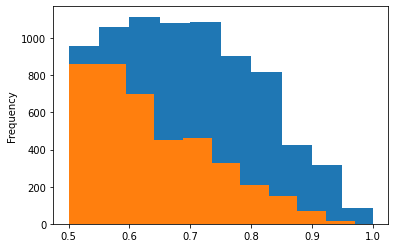

In [64]:
correct_pred = (results_table['game_result'] == results_table['pred_result'])
wrong_pred = (results_table['game_result'] != results_table['pred_result'])

results_table.loc[correct_pred,'propensity'].plot.hist()
results_table.loc[wrong_pred,'propensity'].plot.hist()

In [213]:
upset_threshold = 0.20
upset_matches = ((results_table['strength_diff'] <= -upset_threshold) & results_table['game_result']) \
    | (results_table['strength_diff'] >= upset_threshold) & ~results_table['game_result']

results_table_upset = results_table[upset_matches]
print(f1_score(results_table_upset['game_result'],results_table_upset['pred_result']))
results_table_upset

0.075


,,,game_result,pred_result,propensity,strength_diff
date_game_href,team_id,opp_id,,,,
/boxscores/200612060LAL.html,NOK,LAL,True,False,0.60,-0.205882
/boxscores/201501290LAL.html,CHI,LAL,False,True,0.81,0.377428
/boxscores/202204030OKC.html,OKC,PHO,True,False,0.90,-0.519481
/boxscores/201903050MEM.html,POR,MEM,False,True,0.60,0.234432
/boxscores/201903100GSW.html,GSW,PHO,False,True,0.90,0.468427
...,...,...,...,...,...,...
/boxscores/201412210ORL.html,ORL,PHI,False,True,0.63,0.264828
/boxscores/201404090DEN.html,DEN,HOU,True,True,0.55,-0.246753
/boxscores/200403300MIL.html,IND,MIL,False,False,0.59,0.246575


In [138]:
results_table_nonupset = results_table.drop(results_table_upset.index)
print(f1_score(results_table_nonupset['game_result'],results_table_nonupset['pred_result']))
results_table_nonupset

0.7545229856648542


,,,game_result,pred_result,propensity,strength_diff
date_game_href,team_id,opp_id,,,,
/boxscores/202008070TOR.html,BOS,TOR,True,False,0.64,-0.069579
/boxscores/200112010POR.html,PHO,POR,True,False,0.59,0.025735
/boxscores/201501120BRK.html,BRK,HOU,False,False,0.63,-0.270270
/boxscores/201602070ORL.html,ATL,ORL,False,False,0.51,0.148352
/boxscores/201101280CHI.html,CHI,ORL,True,True,0.78,0.036715
...,...,...,...,...,...,...
/boxscores/201104110MIL.html,MIL,TOR,True,True,0.59,0.137500
/boxscores/201712140CLE.html,CLE,LAL,True,True,0.88,0.329670
/boxscores/201602260IND.html,IND,CHO,False,True,0.65,0.026003


Net Pts

In [81]:
columns = ['game_season_teamA', 'game_location_teamA','rest_days_prior_teamA', 'result_prior_teamA',
 'location_result_prior_teamA', 'h2h_result_prior_teamA', 'pts_teamA', 'opp_pts_teamA', 'net_pts_teamA',

 'game_season_teamB', 'game_location_teamB','rest_days_prior_teamB', 'result_prior_teamB',
 'location_result_prior_teamB', 'h2h_result_prior_teamB', 'pts_teamB', 'opp_pts_teamB','net_pts_teamB'
]

X = X0[columns]
y = y0['net_pts']
# model = RandomForestRegressor()
model = LinearRegression()

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=2)
y_pred = model.fit(X_train,y_train).predict(X_test)
print(r2_score(y_test,y_pred))

0.20459051612223034


In [86]:
results_table = y_test.to_frame()
results_table.loc[:,'pred_net_pts'] = y_pred
results_table.loc[:,'diff'] = y_pred - y_test
results_table.loc[:,['result_prior_teamA','result_prior_teamB']] = X_test[['result_prior_teamA','result_prior_teamB']]

results_table

,,,net_pts,pred_net_pts,diff,result_prior_teamA,result_prior_teamB
date_game_href,team_id,opp_id,,,,,
/boxscores/202008070TOR.html,BOS,TOR,22,-3.101994,-25.101994,0.661765,0.731343
/boxscores/200112010POR.html,PHO,POR,14,0.192389,-13.807611,0.588235,0.562500
/boxscores/201501120BRK.html,BRK,HOU,-14,-3.504068,10.495932,0.432432,0.702703
/boxscores/201602070ORL.html,ATL,ORL,-2,0.373729,2.373729,0.576923,0.428571
/boxscores/201101280CHI.html,CHI,ORL,9,4.192248,-4.807752,0.688889,0.652174
...,...,...,...,...,...,...,...
/boxscores/201602260IND.html,IND,CHO,-1,4.397783,5.397783,0.543860,0.517857
/boxscores/201711240IND.html,IND,TOR,3,0.155524,-2.844476,0.555556,0.647059
/boxscores/200803070LAL.html,LAC,LAL,-37,-12.743988,24.256012,0.338983,0.704918


<AxesSubplot:xlabel='net_pts', ylabel='pred_net_pts'>

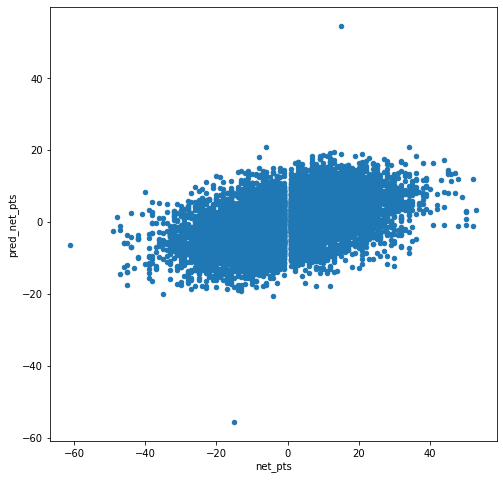

In [83]:
results_table.plot.scatter(x='net_pts',y='pred_net_pts',figsize=(8,8))

Total Pts

In [102]:
columns = ['game_season_teamA', 'game_location_teamA','rest_days_prior_teamA', 'result_prior_teamA',
 'location_result_prior_teamA', 'h2h_result_prior_teamA', 'pts_teamA', 'opp_pts_teamA', 'net_pts_teamA',

 'game_season_teamB', 'game_location_teamB','rest_days_prior_teamB', 'result_prior_teamB',
 'location_result_prior_teamB', 'h2h_result_prior_teamB', 'pts_teamB', 'opp_pts_teamB','net_pts_teamB'
]

X = X0[columns]
y = y0['total_pts']
# model = RandomForestRegressor()
model = LinearRegression()

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=2)
y_pred = model.fit(X_train,y_train).predict(X_test)
print(r2_score(y_test,y_pred))

0.3505541856416824


In [103]:
results_table = y_test.to_frame()
results_table.loc[:,'pred_pts'] = y_pred
results_table.loc[:,'diff'] = y_pred - y_test
results_table.loc[:,['pts_teamA','pts_teamB']] = X_test[['pts_teamA','pts_teamB']]

results_table

,,,total_pts,pred_pts,diff,pts_teamA,pts_teamB
date_game_href,team_id,opp_id,,,,,
/boxscores/202008070TOR.html,BOS,TOR,222,224.425862,2.425862,113.632353,112.746269
/boxscores/200112010POR.html,PHO,POR,180,190.951609,10.951609,99.764706,94.687500
/boxscores/201501120BRK.html,BRK,HOU,212,196.468781,-15.531219,95.540541,101.513514
/boxscores/201602070ORL.html,ATL,ORL,190,202.667634,12.667634,102.211538,99.204082
/boxscores/201101280CHI.html,CHI,ORL,189,192.989557,3.989557,97.822222,100.500000
...,...,...,...,...,...,...,...
/boxscores/201602260IND.html,IND,CHO,191,205.449163,14.449163,102.491228,102.035714
/boxscores/201711240IND.html,IND,TOR,211,217.617624,6.617624,108.888889,109.764706
/boxscores/200803070LAL.html,LAC,LAL,201,203.284592,2.284592,94.016949,107.950820


0.08518166855269006 18.437942036567236


<AxesSubplot:ylabel='Frequency'>

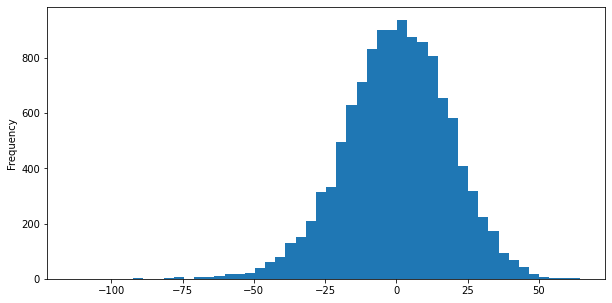

In [104]:
print(results_table['diff'].mean(), results_table['diff'].std())
results_table['diff'].plot.hist(bins=50,figsize=(10,5))

In [107]:
len(results_table['diff'][results_table['diff'].abs() <= 5])/len(results_table['diff'])

0.21736586996490054

In [110]:
results_table.iloc[results_table['diff'].argmin()]

total_pts    318.000000
pred_pts     204.377029
diff        -113.622971
pts_teamA    108.812500
pts_teamB     95.882353
Name: (/boxscores/200612070NJN.html, PHO, NJN), dtype: float64

Upset Threshold

- What quantifies as an upset? W% Difference above a certain threshold
- Goal: Determine the strength difference threshold such that upsets will occur only 10-15%
    - 

In [139]:
y0

,,,pts,opp_pts,game_result,net_pts,total_pts
date_game_href,team_id,opp_id,,,,,
/boxscores/202111090UTA.html,ATL,UTA,98,110,False,-12,208
/boxscores/202111120DEN.html,ATL,DEN,96,105,False,-9,201
/boxscores/202111140ATL.html,ATL,MIL,120,100,True,20,220
/boxscores/202111150ATL.html,ATL,ORL,129,111,True,18,240
/boxscores/202111170ATL.html,ATL,BOS,110,99,True,11,209
...,...,...,...,...,...,...,...
/boxscores/200004120PHI.html,WAS,PHI,84,93,False,-9,177
/boxscores/200004130CHI.html,WAS,CHI,109,103,True,6,212
/boxscores/200004150WAS.html,WAS,MIL,116,120,False,-4,236


In [148]:
y0.mean()

pts            101.227687
opp_pts        101.227687
game_result      0.500000
net_pts          0.000000
total_pts      202.455374
dtype: float64

/var/folders/fr/37hzr_m96pl96wysz0n2sxd40000gn/T/ipykernel_10328/2201171776.py:12: RuntimeWarning: invalid value encountered in long_scalars
  upset_rate_local = upset_result.sum() / clear_favorite_game.sum()


Text(0, 0.5, '% games')

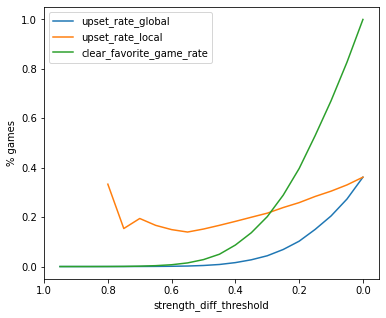

In [211]:
x1 = np.arange(0,1,0.05)
x2 = []
x3 = []
x4 = []
for upset_threshold in x1:
    game_result = y0['game_result']
    strength_diff = X0.loc[:,'result_prior_teamA'] - X0.loc[:,'result_prior_teamB']
    clear_favorite_game = (strength_diff <= -upset_threshold) | (strength_diff >= upset_threshold)
    upset_result = ((strength_diff <= -upset_threshold) & game_result) \
        | ((strength_diff >= upset_threshold) & ~game_result) # Underdog and win or Favorite and loss
    upset_rate_global = upset_result.mean()
    upset_rate_local = upset_result.sum() / clear_favorite_game.sum()
    clear_favorite_game_rate = clear_favorite_game.mean()

    x2.append(upset_rate_global)
    x3.append(upset_rate_local)
    x4.append(clear_favorite_game_rate)
plt.figure(figsize=(6,5))
plt.plot(x1,x2,label='upset_rate_global')
plt.plot(x1,x3,label='upset_rate_local')
plt.plot(x1,x4,label='clear_favorite_game_rate')

plt.legend()
plt.xlim([1,-.05])
plt.xlabel('strength_diff_threshold')
plt.ylabel('% games')

In [212]:
data = pd.DataFrame(list(zip(x4,x2,x3)),index=x1,columns=['has_clear_favorite_pct','upset_pct_global','upset_pct_local'])
data

,has_clear_favorite_pct,upset_pct_global,upset_pct_local
0.00,1.000000,0.361650,0.361650
0.05,0.827010,0.273232,0.330386
0.10,0.670734,0.204621,0.305071
0.15,0.529458,0.150134,0.283561
0.20,0.396749,0.102624,0.258662
0.25,0.288944,0.068987,0.238756
0.30,0.201947,0.043624,0.216015
0.35,0.136930,0.027327,0.199573
0.40,0.087080,0.015920,0.182821
0.45,0.049850,0.008315,0.166806


It seems that upset_threshold 0.15 will yield a 

Goal: